### PART 1: Run SQL queries on the "mpg" database using SQLite and Pandas

In [1]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('./data/mpg.db')
name = pd.read_sql_query(""" SELECT * FROM name """, conn)
observation = pd.read_sql_query(""" SELECT * FROM observation """, conn)
origin = pd.read_sql_query(""" SELECT * FROM origin """, conn)

In [2]:
name.head(2)

,name_id,name
0,0,amc ambassador brougham
1,1,amc ambassador dpl


In [3]:
observation.head(2)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_id,name_id
0,18.0,8,307.0,130.0,3504,12.0,70,2,49
1,15.0,8,350.0,165.0,3693,11.5,70,2,36


In [4]:
origin.head(2)

,origin_id,origin
0,0,europe
1,1,japan


In [5]:
# Select unique values in the model_year column and order them in acsending order. How many unique values are there?

pd.read_sql_query(""" 
                  SELECT COUNT(DISTINCT model_year) AS unique_model_years
                  FROM observation 
                  ORDER BY model_year ASC 
                  """, conn)

,unique_model_years
0,13


In [6]:
# If a vehicle is older than 45 years, then label it as "45+". Otherwise, label it as "<45". 
# Create a new column that takes these two values

pd.read_sql_query(""" 
                  SELECT *, CASE WHEN 2023 - (model_year+1900) > 45 THEN '45+' ELSE '<45' END AS age_group
                  FROM observation
                  """, conn)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_id,name_id,age_group
0,18.0,8,307.0,130.0,3504,12.0,70,2,49,45+
1,15.0,8,350.0,165.0,3693,11.5,70,2,36,45+
2,18.0,8,318.0,150.0,3436,11.0,70,2,231,45+
3,16.0,8,304.0,150.0,3433,12.0,70,2,14,45+
4,17.0,8,302.0,140.0,3449,10.5,70,2,161,45+
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,2,153,<45
394,44.0,4,97.0,52.0,2130,24.6,82,0,301,<45
395,32.0,4,135.0,84.0,2295,11.6,82,2,119,<45
396,28.0,4,120.0,79.0,2625,18.6,82,2,159,<45


In [7]:
# List all unique vehicle name values that have 8 cylinders with horsepower that is greater than 125 but doesn't exceed 200

pd.read_sql_query("""
                  SELECT DISTINCT t2.name, t1.cylinders, t1.horsepower
                  FROM observation t1
                  LEFT JOIN name t2
                  ON t1.name_id = t2.name_id
                  WHERE t1.cylinders = 8 AND t1.horsepower > 125 AND t1.horsepower < 200
                  """, conn)

,name,cylinders,horsepower
0,chevrolet chevelle malibu,8,130.0
1,buick skylark 320,8,165.0
2,plymouth satellite,8,150.0
3,amc rebel sst,8,150.0
4,ford torino,8,140.0
...,...,...,...
74,mercury grand marquis,8,138.0
75,dodge st. regis,8,135.0
76,buick estate wagon (sw),8,155.0
77,ford country squire (sw),8,142.0


In [8]:
# Group by cylinder and then find the best mpg for each cylinder value and display the country of origin and name

pd.read_sql_query("""
                    SELECT t1.cylinders, t1.mpg, t2.origin, t3.name
                    FROM observation t1
                    LEFT JOIN origin t2
                    ON t1.origin_id = t2.origin_id
                    LEFT JOIN name t3
                    ON t1.name_id = t3.name_id
                    WHERE t1.mpg IN (SELECT MAX(mpg) FROM observation GROUP BY cylinders)

                  """, conn)

,cylinders,mpg,origin,name
0,4,46.6,japan,mazda glc
1,5,36.4,europe,audi 5000s (diesel)
2,3,23.7,japan,mazda rx-7 gs
3,4,26.6,usa,buick skylark
4,8,26.6,usa,oldsmobile cutlass ls
5,4,38.0,usa,plymouth horizon miser
6,4,38.0,japan,honda civic
7,4,38.0,japan,datsun 310 gx
8,6,38.0,usa,oldsmobile cutlass ciera (diesel)


In [9]:
# Find the best mpg for each cylinder value and display the country of origin and name

pd.read_sql_query("""
                    SELECT MAX(mpg) AS max_mpg, cylinders, origin, name
                    FROM observation t1
                    LEFT JOIN origin t2
                    ON t1.origin_id = t2.origin_id
                    LEFT JOIN name t3
                    ON t1.name_id = t3.name_id
                    GROUP BY cylinders
                  """, conn)

,max_mpg,cylinders,origin,name
0,23.7,3,japan,mazda rx-7 gs
1,46.6,4,japan,mazda glc
2,36.4,5,europe,audi 5000s (diesel)
3,38.0,6,usa,oldsmobile cutlass ciera (diesel)
4,26.6,8,usa,oldsmobile cutlass ls


### PART 2: Build a machine learning pipeline to find the best estimator for predicting mpg

In [10]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
observation.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_id,name_id
0,18.0,8,307.0,130.0,3504,12.0,70,2,49
1,15.0,8,350.0,165.0,3693,11.5,70,2,36
2,18.0,8,318.0,150.0,3436,11.0,70,2,231
3,16.0,8,304.0,150.0,3433,12.0,70,2,14
4,17.0,8,302.0,140.0,3449,10.5,70,2,161


In [12]:
observation = observation.dropna()

In [13]:
# define categorical variables
cat_col = observation[['cylinders', 'model_year', 'origin_id']].astype('category')

# convert categorical varaibles to dummy variables
cat_col = pd.get_dummies(cat_col, drop_first=True, dtype=float)
cat_col.head()

,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model_year_71,model_year_72,model_year_73,model_year_74,model_year_75,model_year_76,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_id_1,origin_id_2
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# define continuous variables and final dataset

con_col = observation.drop(['mpg', 'cylinders', 'model_year', 'origin_id', 'name_id'], axis=1)
X = pd.concat([con_col, cat_col], axis=1)
y = observation['mpg'] # target variable
X.head() # independent variables

,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_5,cylinders_6,cylinders_8,model_year_71,model_year_72,...,model_year_75,model_year_76,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,origin_id_1,origin_id_2
0,307.0,130.0,3504,12.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,350.0,165.0,3693,11.5,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,318.0,150.0,3436,11.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,304.0,150.0,3433,12.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,302.0,140.0,3449,10.5,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [16]:
# design a training pipeline

def train_pipeline(pipeline):
    result = {}

    scaler = pipeline.steps[0][1].__class__.__name__
    regressor = pipeline.steps[1][1].__class__.__name__
    result['model'] = regressor
    result['scaler'] = scaler if scaler != 'NoneType' else 'No Scaling'
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    result['mse'] =  mean_squared_error(y_test, y_pred)

    return result 


In [17]:
# train and evaluate different models with different scalers

scalers = [None, StandardScaler(), MinMaxScaler()]
regressors = [KNeighborsRegressor(), LinearRegression(), XGBRegressor(), SVR(), RandomForestRegressor(), DecisionTreeRegressor()]

eval_data = []
for reg in regressors:
    for sc in scalers:
        pipeline = Pipeline([('scaler', sc), ('reg', reg)])
        eval_data.append(train_pipeline(pipeline))

In [18]:
results = pd.DataFrame(eval_data).sort_values(by='mse').reset_index(drop=True)
results

,model,scaler,mse
0,LinearRegression,MinMaxScaler,8.580161
1,LinearRegression,No Scaling,8.580161
2,LinearRegression,StandardScaler,8.729275
3,XGBRegressor,StandardScaler,9.055346
4,XGBRegressor,No Scaling,9.056461
5,XGBRegressor,MinMaxScaler,9.057474
6,RandomForestRegressor,No Scaling,9.614873
7,RandomForestRegressor,MinMaxScaler,9.893013
8,RandomForestRegressor,StandardScaler,10.053417
9,SVR,StandardScaler,12.778129


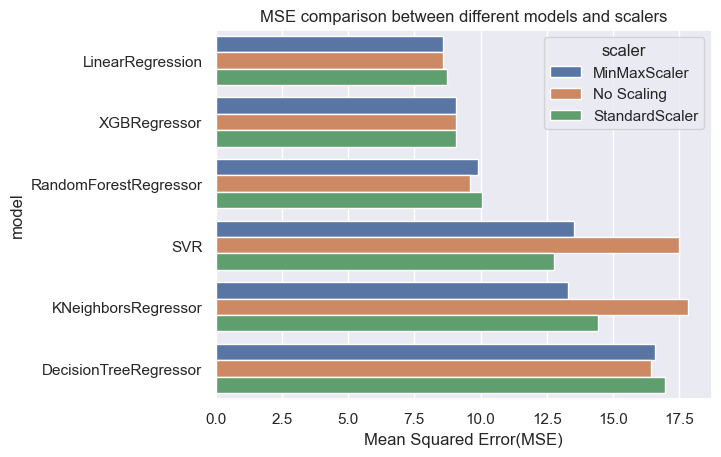

In [19]:
# By plotting the results, we can see that the best model is actually simple Linear Regression model with or without scaling

sns.barplot(x='mse', y='model', hue='scaler', data=results)
plt.title('MSE comparison between different models and scalers')
plt.xlabel('Mean Squared Error(MSE)');